In [1]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import fft
from operator import itemgetter
from sklearn.decomposition import PCA


%matplotlib inline

In [5]:
def get_dataset(file_name):
    to_split = file_name.split("/")[-1]
    return to_split.split("_")[0]

def get_filename(f,method,lbr,ep=0.200,b=50,s=20):
    f = "batch/baseline/{}_b{}_s{}_lbr{:.3f}_ep{:.3f}_{}.csv".format(f,b,s,lbr,ep,method)
    return f

def get_data_from_csv(files):
    data_matrices = []
    for f in files:
        data_matrices += [np.loadtxt("../../../../../../../test/resources/data/optimizer/raw/{}.csv".format(f), delimiter=",")]
    return data_matrices

def cut_sample(getter, data, k):
    return np.array(getter(data[:,:k]))

def distance(d1, d2, const=1, order=2, kernel=False):
    if len(d1.shape) == 1 and not kernel: #both d1, d2 should always be the same
        return np.linalg.norm(d1-d2,ord=order)/np.sqrt(const)
    if not kernel:
        return np.linalg.norm(d1-d2, axis=1, ord=order)/np.sqrt(const)
    if kernel:
        return rbf_kernel(d1,d2,1)/np.sqrt(const)

In [6]:
lbr = 0.980
methods = ["FFT", "PAA", "PCA"]
datasets = ['50words', 'Adiac', 'ArrowHead', 'Car', 'CBF', 'ChlorineConcentration', 'CinC', 'Computers', 'Cricket', 'Cricket', 'Cricket', 'DiatomSizeReduction', 'DistalPhalanxOutlineAgeGroup', 'DistalPhalanxOutlineCorrect', 'DistalPhalanxTW', 'Earthquakes', 'ECG200', 'ECG5000', 'ECGFiveDays', 'ElectricDevices', 'FaceAll', 'FaceFour', 'FacesUCR', 'FISH', 'FordA', 'FordB', 'Gun', 'Ham', 'HandOutlines', 'Haptics', 'Herring', 'InlineSkate', 'InsectWingbeatSound', 'ItalyPowerDemand', 'LargeKitchenAppliances', 'Lighting2', 'Lighting7', 'MALLAT', 'Meat', 'MedicalImages', 'MiddlePhalanxOutlineAgeGroup', 'MiddlePhalanxOutlineCorrect', 'MiddlePhalanxTW', 'MoteStrain', 'NonInvasiveFatalECG', 'NonInvasiveFatalECG', 'OSULeaf', 'PhalangesOutlinesCorrect', 'Phoneme', 'Plane', 'ProximalPhalanxOutlineAgeGroup', 'ProximalPhalanxOutlineCorrect', 'ProximalPhalanxTW', 'RefrigerationDevices', 'ScreenType', 'ShapeletSim', 'ShapesAll', 'SmallKitchenAppliances', 'SonyAIBORobotSurface', 'SonyAIBORobotSurfaceII', 'StarLightCurves', 'Strawberry', 'SwedishLeaf', 'Symbols', 'synthetic', 'ToeSegmentation1', 'ToeSegmentation2', 'Trace', 'TwoLeadECG', 'Two', 'UWaveGestureLibraryAll', 'uWaveGestureLibrary', 'uWaveGestureLibrary', 'uWaveGestureLibrary', 'wafer', 'Wine', 'WordsSynonyms', 'Worms', 'WormsTwoClass', 'yoga']

In [7]:
plt.rcParams['figure.figsize'] = 10,5
plt.rcParams['font.size'] = 20
plt.rcParams['font.sans-serif'] = "Helvetica"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.width'] = 1


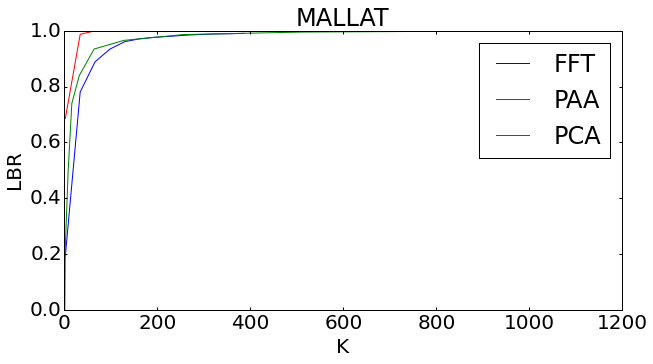

In [12]:
mapping = ["MALLAT"]#["CinC", "Two", "ElectricDevices", "ECG5000", "Computers" ]
for f in mapping:
    plt.figure()
    plt.hold(True)
    for method in methods:
        file_name = get_filename(f, method, lbr)
        try:
            data = np.loadtxt(file_name, delimiter=',') 
            sorted_data = data[np.argsort(data[:,0])]
            plt.ylim((0,1.00))
            plt.plot(sorted_data[:,0],sorted_data[:,1], label=method)
            plt.title(f)
            plt.xlabel("K")
            plt.ylabel("LBR")
        except IOError:
            pass
    plt.legend()
    plt.show()


In [11]:
data = np.loadtxt(file_name, delimiter=',') 


IOError: [Errno 2] No such file or directory: 'batch/baseline/MALLAT_b50_s20_lbr0.980_ep0.200_PCA.csv'

In [30]:
#PCA
data_matrices = get_data_from_csv(mapping)#loadKeoghMappingStuff
LBR_matrices = []
for ii, data_matrix in enumerate(data_matrices):
    print mapping[ii]
    data_matrix = data_matrices[ii]
    NUM_POINTS, N = data_matrix.shape
    KS = range(50)

    LBR_matrix = np.zeros(len(KS))


    KBOOTSTRAP = NUM_POINTS

    #NUM_PCA_TRAIN = int(1*NUM_POINTS)

    listA = np.random.randint(0,NUM_POINTS, KBOOTSTRAP)
    listB = np.random.randint(0,NUM_POINTS, KBOOTSTRAP)
    pairs = filter(lambda (x,y): x != y, zip(listA, listB))
    filtA, filtB = zip(*pairs)

    getA = itemgetter(*listA)
    getB = itemgetter(*listB)

    PCA_FULL = PCA(n_components=N)
    full_PCA = PCA_FULL.fit_transform(data_matrix)

    #PCA_TRAIN = PCA(n_components=WINDOW)
    #train_PCA = PCA_TRAIN.fit(data_matrix)
    #test_PCA = PCA_TRAIN.transform(data_matrix)

    true_dists = distance(cut_sample(getA, data_matrix, N), cut_sample(getB, data_matrix, N)) 

    for j, k in enumerate(KS):
        PCA_matrix = full_PCA[:,:k] 
        PCA_matrix_dists = distance(cut_sample(getA, PCA_matrix, k), cut_sample(getB, PCA_matrix, k))
        LBR_matrix[j] = np.nanmean(PCA_matrix_dists/true_dists)

    LBR_matrices += [LBR_matrix]

CinC


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in divide


Two
ElectricDevices
ECG5000
Computers


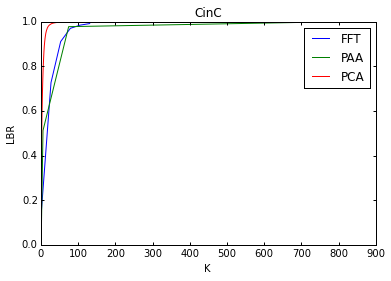

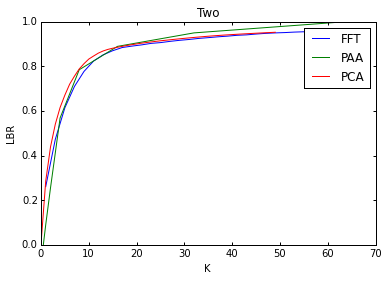

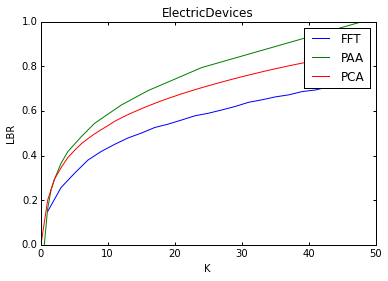

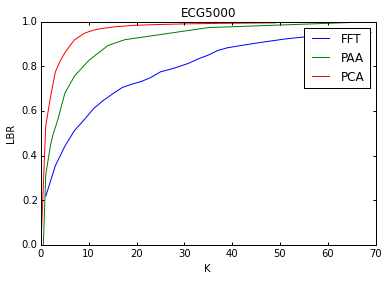

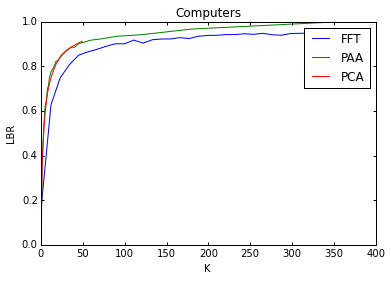

In [32]:
for i, f in enumerate(mapping):
    plt.figure()
    plt.hold(True)
    for method in methods:
        file_name = get_filename(f, method, lbr)
        try:
            data = np.loadtxt(file_name, delimiter=',') 
            sorted_data = data[np.argsort(data[:,0])]
            plt.ylim((0,1.00))
            plt.plot(sorted_data[:,0]/2,sorted_data[:,1], label=method)
            plt.title(f)
            plt.xlabel("K")
            plt.ylabel("LBR")
        except IOError:
            pass
    plt.plot(LBR_matrices[i], label = "PCA")
    plt.legend()
    plt.show()




In [37]:
ff = "../../../../../../../../src/test/resources/data/optimizer/raw/{}.csv".format("WordsSynonyms")
a = np.loadtxt(ff, delimiter=",")

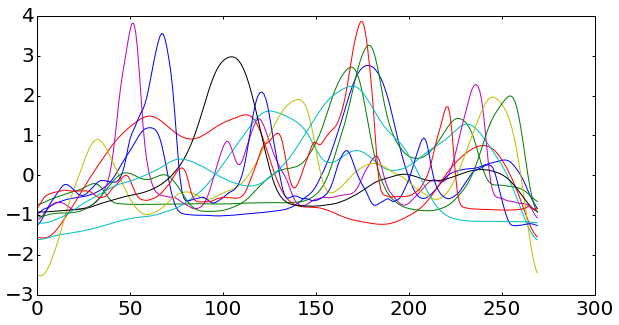

In [38]:
plt.figure()
plt.hold(True)
for i in range(1, a.shape[0], a.shape[0]/10):
    plt.plot(a[i])

In [5]:
def PAA(data_matrix, k):
    N = data_matrix.shape[1]
    if N%k == 0:
        return float(k)/N * np.add.reduceat(data_matrix, range(0,N, int(N/k)), axis=1)
    midpoints = [np.mean([float(N-1)/k * i,float(N-1)/k * (i+1)]) for i in range(k)]
    interpolated = interp1d(np.arange(N),data_matrix, axis=1)
    return interpolated(midpoints)

def FFT(data_matrix, k):
    transformed = fft(data_matrix)
    #lol super inefficient
    sorted_FFT = np.argsort(-np.abs(transformed), axis=1)
    top_k_counter = {}
    for indices in sorted_FFT:
        for i in indices[:k]:
            if i not in top_k_counter.keys():
                top_k_counter[i] = 0
            top_k_counter[i] += 1           
    sorted_by_appearance = sorted(top_k_counter.items(), key=lambda x: -x[1])
    top_indices = [i[0] for i in sorted_by_appearance[:k]]
    return transformed[:, top_indices]

NameError: name 'a' is not defined